
# Max Colorable Induced Subgraph Problem



## Background

Given a graph $G = (V,E)$ and number of colors K, find the **largest induced subgraph that can be colored using up to K colors**.

A coloring is legal if:

- each vetrex ${v_i}$ is assigned with a color $k_i \in \{0, 1, ..., k-1\}$
- adajecnt vertex have different colors: for each $v_i, v_j$ such that $(v_i, v_j) \in E$, $k_i \neq k_j$.

An induced subgraph of a graph $G = (V,E)$ is a graph $G'=(V', E')$ such that $V'\subset V$ and $E' = \{(v_1, v_2) \in E\ |\ v_1, v_2 \in V'\}$.


## Define the optimization problem

In [1]:
import networkx as nx
import numpy as np
import pyomo.environ as pyo


def define_max_k_colorable_model(graph, K):
    model = pyo.ConcreteModel()

    nodes = list(graph.nodes())
    colors = range(0, K)

    # each x_i states if node i belongs to the cliques
    model.x = pyo.Var(colors, nodes, domain=pyo.Binary)
    x_variables = np.array(list(model.x.values()))

    adjacency_matrix = nx.convert_matrix.to_numpy_array(graph, nonedge=0)
    adjacency_matrix_block_diagonal = np.kron(np.eye(K), adjacency_matrix)

    # constraint that 2 nodes sharing an edge mustn't have the same color
    model.conflicting_color_constraint = pyo.Constraint(
        expr=x_variables @ adjacency_matrix_block_diagonal @ x_variables == 0
    )

    # each node should be colored
    @model.Constraint(nodes)
    def each_node_is_colored_once_or_zero(model, node):
        return sum(model.x[color, node] for color in colors) <= 1

    def is_node_colored(node):
        is_colored = np.prod([(1 - model.x[color, node]) for color in colors])
        return 1 - is_colored

    # maximize the number of nodes in the chosen clique
    model.value = pyo.Objective(
        expr=sum(is_node_colored(node) for node in nodes), sense=pyo.maximize
    )

    return model

### Initialize the model with parameters

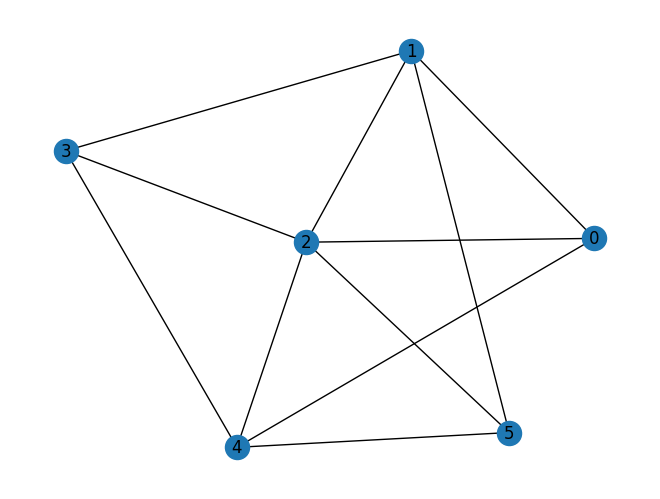

In [2]:
graph = nx.erdos_renyi_graph(6, 0.5, seed=7)
nx.draw_kamada_kawai(graph, with_labels=True)

NUM_COLORS = 2

coloring_model = define_max_k_colorable_model(graph, NUM_COLORS)

### print the resulting pyomo model

In [3]:
coloring_model.pprint()

4 Set Declarations
    each_node_is_colored_once_or_zero_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    6 : {0, 1, 2, 3, 4, 5}
    x_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain              : Size : Members
        None :     2 : x_index_0*x_index_1 :   12 : {(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5)}
    x_index_0 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {0, 1}
    x_index_1 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    6 : {0, 1, 2, 3, 4, 5}

1 Var Declarations
    x : Size=12, Index=x_index
        Key    : Lower : Value : Upper : Fixed : Stale : Domain
        (0, 0) :     0 :  None :     1 : False :  True : Binary
        (0, 1) :     0 :  None :     1 : False :  T

## Setting Up the Classiq Problem Instance

In order to solve the Pyomo model defined above, we use the `CombinatorialProblem` python class. Under the hood it translates the Pyomo model to a quantum model of the QAOA algorithm [[1](#QAOA)], with cost hamiltonian translated from the Pyomo model. We can choose the number of layers for the QAOA ansatz using the argument `num_layers`.

In [4]:
from classiq import *
from classiq.applications.combinatorial_optimization import CombinatorialProblem

combi = CombinatorialProblem(pyo_model=coloring_model, num_layers=8)

qmod = combi.get_model()

In [5]:
write_qmod(qmod, "max_induced_k_color_subgraph")

## Synthesizing the QAOA Circuit and Solving the Problem

We can now synthesize and view the QAOA circuit (ansatz) used to solve the optimization problem:

In [6]:
qprog = combi.get_qprog()
show(qprog)

Quantum program link: https://nightly.platform.classiq.io/circuit/2zp7rUct3AEXP94PXeNWwoZkiVI


We now solve the problem by calling the `optimize` method of the `CombinatorialProblem` object. For the classical optimization part of the QAOA algorithm we define the maximum number of classical iterations (`maxiter`) and the $\alpha$-parameter (`quantile`) for running CVaR-QAOA, an improved variation of the QAOA algorithm [[2](#cvar)]:

In [21]:
optimized_params = combi.optimize(maxiter=50, quantile=0.7)

We can check the convergence of the run:

Text(0.5, 1.0, 'Cost convergence')

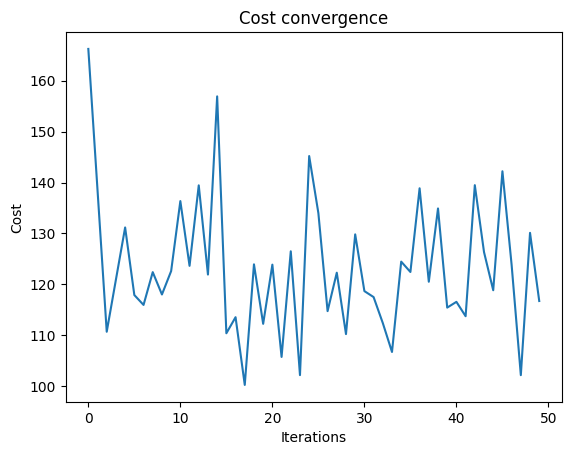

In [22]:
import matplotlib.pyplot as plt

plt.plot(combi.cost_trace)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Cost convergence")

## Optimization Results

We can also examine the statistics of the algorithm. The optimization is always defined as a minimzation problem, so the positive maximization objective was tranlated to a negative minimization one by the Pyomo to qmod translator.

In order to get samples with the optimized parameters, we call the `sample` method:

In [23]:
optimization_result = combi.sample(optimized_params)
optimization_result.sort_values(by="cost").head(5)

,solution,probability,cost
1153,"{'x': [[0, 1, 0, 0, 1, 0], [1, 0, 0, 1, 0, 1]]}",0.000488,-5
546,"{'x': [[0, 1, 0, 0, 1, 0], [1, 0, 0, 0, 0, 1]]}",0.000488,-4
500,"{'x': [[1, 0, 0, 1, 0, 1], [0, 0, 1, 0, 0, 0]]}",0.000488,-4
1170,"{'x': [[0, 1, 0, 0, 1, 0], [1, 0, 0, 1, 0, 0]]}",0.000488,-4
1070,"{'x': [[1, 0, 0, 0, 0, 1], [0, 1, 0, 0, 1, 0]]}",0.000488,-4


We will also want to compare the optimized results to uniformly sampled results:

In [24]:
uniform_result = combi.sample_uniform()

And compare the histograms:

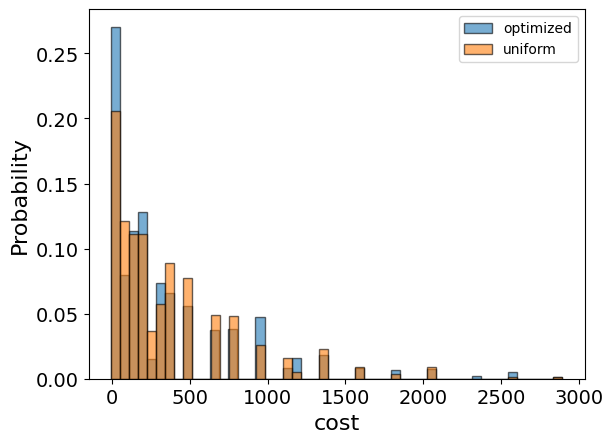

In [25]:
optimization_result["cost"].plot(
    kind="hist",
    bins=50,
    edgecolor="black",
    weights=optimization_result["probability"],
    alpha=0.6,
    label="optimized",
)
uniform_result["cost"].plot(
    kind="hist",
    bins=50,
    edgecolor="black",
    weights=uniform_result["probability"],
    alpha=0.6,
    label="uniform",
)
plt.legend()
plt.ylabel("Probability", fontsize=16)
plt.xlabel("cost", fontsize=16)
plt.tick_params(axis="both", labelsize=14)

Let us plot the best solution:

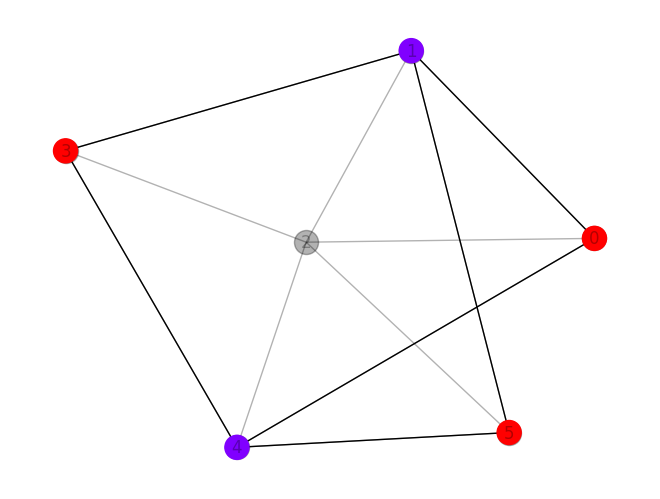

In [26]:
import matplotlib.pyplot as plt

best_solution = optimization_result.solution[optimization_result.cost.idxmin()]["x"]

one_hot_solution = np.array(best_solution).reshape([NUM_COLORS, len(graph.nodes)])
integer_solution = np.argmax(one_hot_solution, axis=0)

colored_nodes = np.array(graph.nodes)[one_hot_solution.sum(axis=0) != 0]
colors = integer_solution[colored_nodes]

pos = nx.kamada_kawai_layout(graph)
nx.draw(graph, pos=pos, with_labels=True, alpha=0.3, node_color="k")
nx.draw(graph.subgraph(colored_nodes), pos=pos, node_color=colors, cmap=plt.cm.rainbow)


## References

<a id='QAOA'>[1]</a>: [Farhi, Edward, Jeffrey Goldstone, and Sam Gutmann. "A quantum approximate optimization algorithm." arXiv preprint arXiv:1411.4028 (2014).](https://arxiv.org/abs/1411.4028)

<a id='cvar'>[2]</a>: [Barkoutsos, Panagiotis Kl, et al. "Improving variational quantum optimization using CVaR." Quantum 4 (2020): 256.](https://arxiv.org/abs/1907.04769)
